In [55]:
import numpy as np 
from PIL import Image 
import matplotlib.pyplot as plt 
import cv2 

import torch 
from torchvision import transforms 
import torch.nn.functional as F 
import torch.nn as nn 

from src.data.augmentation import *
from src.data.factory import create_dataset,create_dataloader
from src.train import torch_seed
from src.options import Options

In [57]:
def model_load(root):
    model = torch.load(root)
    return model

def prepare():
    cfg = Options().to_dict()
    cfg['device'] = 'cuda:1'
    torch_seed(cfg['seed'])

    root = './save_models/Baseline/best.pt'
    model = model_load(root).to(cfg['device'])
    
    cfg['transform'] = transforms.Compose([transforms.ToTensor()])
    
    
    trainset,testset = create_dataset(cfg)
    test_loader = create_dataloader(testset,
                                        cfg['Batchsize'],
                                        shuffle=True)

    return cfg,model,testset,trainset,test_loader
cfg,model,testset,trainset,test_loader = prepare()

In [76]:
model.eval()
loss_map = np.zeros((len(test_loader.dataset),cfg['imgsize'],cfg['imgsize']))
i = 0 
mseloss = nn.MSELoss(reduction='sum')
for step,(batch_imgs,batch_msks) in enumerate(test_loader):
    batch_imgs = batch_imgs.type(torch.float32).to(cfg['device'])
    
    batch_loss_map = np.zeros((32,cfg['imgsize'],cfg['imgsize'],1))    
    t_features,s_features = model(batch_imgs)
    for t_f,s_f in zip(t_features,s_features):
        t_f = F.normalize(t_f,dim=1)
        s_f = F.normalize(s_f,dim=1)
        sm = torch.sum((t_f.type(torch.float32) - s_f.type(torch.float32))**2,dim=1,keepdim=True)
        sm = torch.permute(sm,(0,2,3,1)).detach().cpu().numpy()
        sm = np.array([cv2.resize(i,dsize=(cfg['imgsize'],cfg['imgsize'])) for i in sm])
        sm = np.expand_dims(sm,-1)
        batch_loss_map += sm
    break
    

In [58]:
model.eval()
loss_map = np.zeros((len(test_loader.dataset),cfg['imgsize'],cfg['imgsize']))
i = 0 
mseloss = nn.MSELoss(reduction='sum')
for step,(batch_imgs,batch_msks) in enumerate(test_loader):
    batch_imgs = batch_imgs.type(torch.float32).to(cfg['device'])
    
    batch_loss_map = torch.zeros((32,1,64,64)).to(cfg['device'])
    t_features,s_features = model(batch_imgs)
    for t_f,s_f in zip(t_features,s_features):
        t_f = F.normalize(t_f,dim=1)
        s_f = F.normalize(s_f,dim=1)
        sm = torch.sum((t_f.type(torch.float32) - s_f.type(torch.float32))**2,dim=1,keepdim=True)
        sm = F.interpolate(sm, size=(64, 64), mode='bilinear', align_corners=False)
        batch_loss_map += sm
    break
    

In [78]:
sm.shape

(32, 256, 256, 1)

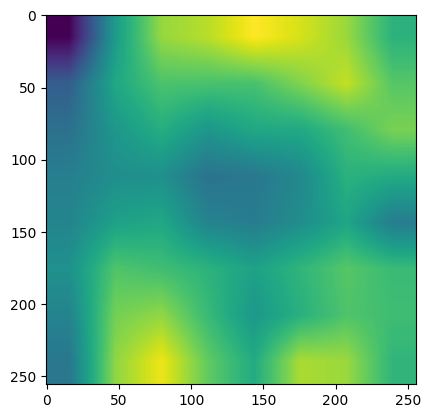

In [79]:
#temp = torch.permute(sm,(0,2,3,1)).detach().cpu().numpy()
plt.imshow(sm[3])
        
    